El presente proyecto analiza datos relacionados con el servicio de taxis en Chicago durante noviembre de 2017, utilizando un enfoque de ciencia de datos para extraer patrones significativos y tomar decisiones informadas.

**Metodología**

**Importación y Preparación de los Datos:**

Los datos fueron obtenidos de bases relacionales y organizados en tres conjuntos principales:

- Información sobre el número de viajes por compañía.
- Promedio de viajes por barrio.
- Condiciones meteorológicas y duración de viajes en días específicos.
- Se procesaron para garantizar calidad, corrigiendo valores atípicos, y ajustando formatos para facilitar el análisis.

**Análisis Exploratorio de Datos (EDA):**

Se realizaron estudios detallados para comprender la distribución de los datos y su comportamiento. Esto incluyó:
 
- Identificar las compañías líderes en términos de viajes.
- Examinar los barrios con mayor promedio de finalizaciones de viaje.
- Explorar tendencias relacionadas con condiciones climáticas adversas.

**Procesamiento de Valores Atípicos:**

Se identificaron y eliminaron registros anómalos, como viajes con duración de cero segundos, para mejorar la calidad del análisis. Adicionalmente, se ajustaron valores para reducir el impacto de sesgos extremos.

**Pruebas de Hipótesis:**

Se plantearon hipótesis relacionadas con la duración promedio de viajes en condiciones climáticas adversas. Utilizando pruebas estadísticas como el test T-student, se evaluaron las diferencias en duración de trayectos en días lluviosos y días con clima favorable.

**Conclusiones y Recomendaciones:**

Los resultados del análisis se sintetizaron para proporcionar insights relevantes. Se sugirieron estrategias para optimizar servicios de transporte, como la implementación de ofertas específicas en días lluviosos y la reorientación de recursos hacia áreas con mayor demanda.

## Importe de Datos

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math 
import numpy as np
from scipy import stats as st
from scipy.stats import shapiro, normaltest
from scipy.stats import levene, ttest_ind
from scipy.stats import ks_2samp

In [ ]:
company_trips_info = pd.read_csv('/datasets/project_sql_result_01.csv')
trips_info = pd.read_csv('/datasets/project_sql_result_04.csv')
weather_trips = pd.read_csv('/datasets/project_sql_result_07.csv')


display(company_trips_info.sample(10))
display(trips_info.sample(10))
display(weather_trips.sample(10))

,company_name,trips_amount
16,Blue Diamond,2070
37,1469 - 64126 Omar Jada,36
29,303 Taxi,250
21,American United,1404
33,Metro Jet Taxi A,146
41,Chicago Star Taxicab,29
3,Yellow Cab,9888
2,Medallion Leasing,10367
61,5874 - 73628 Sergey Cab Corp.,5
32,Leonard Cab Co,147


,dropoff_location_name,average_trips
30,United Center,178.900000
42,Garfield Park,65.766667
15,Garfield Ridge,745.400000
89,Mount Greenwood,3.137931
93,Riverdale,1.800000
45,Boystown,53.966667
41,North Park,67.833333
72,South Chicago,13.000000
63,Andersonville,16.866667
34,Humboldt Park,97.866667


,start_ts,weather_conditions,duration_seconds
754,2017-11-18 15:00:00,Good,3240.0
978,2017-11-18 08:00:00,Bad,1620.0
877,2017-11-18 06:00:00,Good,1520.0
955,2017-11-04 18:00:00,Bad,1775.0
667,2017-11-11 13:00:00,Good,2040.0
698,2017-11-11 10:00:00,Good,1920.0
426,2017-11-11 07:00:00,Good,1443.0
21,2017-11-11 04:00:00,Good,1260.0
441,2017-11-11 13:00:00,Good,2091.0
365,2017-11-04 12:00:00,Good,2761.0


## Estudio de datos

# 2.1 Estudio de datos company_trips_info

A continuación se realiza estudio sobre el tipo de datos que tenemos, su calidad, y qué valor podríamos agregar para sacarle el mayor provecho

In [ ]:
#comparación de inicio y fin del dataframe:

display(company_trips_info.head(5))
display(company_trips_info.tail(5))

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


,company_name,trips_amount
59,4053 - 40193 Adwar H. Nikola,7
60,2733 - 74600 Benny Jona,7
61,5874 - 73628 Sergey Cab Corp.,5
62,2241 - 44667 - Felman Corp,3
63,3556 - 36214 RC Andrews Cab,2


In [ ]:
# Información preliminar del Dataframe 

print(company_trips_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None


Podemos apreciar a simple vista que el contenido del dataframe es simple, ya que tiene 2 columnas con 64 entradas; company_name con datos tipo 'object' que muestran los nombres de la compañía y `trips_amount` con datos tipo 'int' que muestran la cantidad de viajes en el período de tiempo entre el 15 y 16 de noviembre. Ambas columnas no poseen valores ausentes a simple vista. 

In [ ]:
#Evaluemos los rangos de información de la columna 'trips_amount'

company_trips_info['trips_amount'].describe()

count       64.000000
mean      2145.484375
std       3812.310186
min          2.000000
25%         20.750000
50%        178.500000
75%       2106.500000
max      19558.000000
Name: trips_amount, dtype: float64

Podemos apreciar que el mínmo de viajes en esta muestra es 2, el máximo 19558 y el promedio 2145.48 .Solo 25% de las empresas de esta muestra alcanza el promedio/media del total de viajes. La media (2145.48) es mayor a la mediana (178.5) Esto sugiere una distribución sesgada hacia valores más altos, dado que la media es mucho mayor que la mediana, respaldando la presencia de valores atípicamente altos. tomando en cuenta eso, podríamos dividir la población en 2 partes y poder analizar caracteres interesantes y la diferencia entres estas. 

A continuación, realizaremos un estudio mas profundo sobre los datos de esta tabla, revisaremos si hay valores ausentes 'disimulados' y duplicados, siendo esto enfocado en la columna `company_name` ya que contiene valores tipo object, y apuntan a ser valores únicos.

# Valores Ausentes company_trips_info

In [ ]:
# Comprobamos a fondo si no hay valores ausentes con el método unique 

lost_val1 = company_trips_info['company_name'].unique()

print(lost_val1)

print()

print("Entradas en la columna 'company_name' : " ,  company_trips_info['company_name'].nunique())

['Flash Cab' 'Taxi Affiliation Services' 'Medallion Leasing' 'Yellow Cab'
 'Taxi Affiliation Service Yellow' 'Chicago Carriage Cab Corp'
 'City Service' 'Sun Taxi' 'Star North Management LLC'
 'Blue Ribbon Taxi Association Inc.' 'Choice Taxi Association'
 'Globe Taxi' 'Dispatch Taxi Affiliation' 'Nova Taxi Affiliation Llc'
 'Patriot Taxi Dba Peace Taxi Association' 'Checker Taxi Affiliation'
 'Blue Diamond' 'Chicago Medallion Management' '24 Seven Taxi'
 'Chicago Medallion Leasing INC' 'Checker Taxi' 'American United'
 'Chicago Independents' 'KOAM Taxi Association' 'Chicago Taxicab'
 'Top Cab Affiliation' 'Gold Coast Taxi' 'Service Taxi Association'
 '5 Star Taxi' '303 Taxi' 'Setare Inc' 'American United Taxi Affiliation'
 'Leonard Cab Co' 'Metro Jet Taxi A' 'Norshore Cab'
 '6742 - 83735 Tasha Ride Inc' '3591 - 63480 Chuks Cab'
 '1469 - 64126 Omar Jada' '6743 - 78771 Luhak Corp'
 '0118 - 42111 Godfrey S. Awir' '6574 - Babylon Express Inc.'
 'Chicago Star Taxicab' '1085 - 72312 N and W 

Podemos presenciar con este método, que cada valor/entrada en esta columna no contiene valores ausentes disimulados, como lo poedmos presenciar en algunos casos como 'none','blank','NA' 

# Valores Duplicados company_trips_info

In [ ]:
# Comprobamos si hay filas duplicadas 

df_dup = company_trips_info.duplicated()
df_dup_sum = df_dup.sum()

if df_dup_sum > 0: 
    print('Hay filas duplicadas')
    print('Cantidad de filas duplicadas:' , df_dup_sum)
    duplicated_rows = company_trips_info[df_dup]
    print('filas duplicadas:' , duplicated_rows)
else:
    print('Cantidda de filas duplicadas:' , df_dup_sum)
    print('No hay filas dupicadas')

Cantidda de filas duplicadas: 0
No hay filas dupicadas


In [ ]:
# Comprobamos la cantidad de veces que aparecen los valores en la columna company_name:

dup_val1 = company_trips_info['company_name'].value_counts()

dup_val1 = dup_val1.sort_index()

print('número de veces que aparece un mismo valor en la columna : ')
print()
print(dup_val1)

print('-------------------------------------------------------------------------------------------------------------------')

# comprobamos duplicados, cambiando los nombres a minúscula. 

print('Nombres únicos:' , company_trips_info['company_name'].nunique())

company_name_low = len(company_trips_info['company_name'].str.lower().unique())

print('Nombres únicos minúscula:', company_name_low)



número de veces que aparece un mismo valor en la columna : 

0118 - 42111 Godfrey S. Awir       1
1085 - 72312 N and W Cab Co        1
1469 - 64126 Omar Jada             1
2092 - 61288 Sbeih Company         1
2192 - 73487 Zeymane Corp          1
                                  ..
Sun Taxi                           1
Taxi Affiliation Service Yellow    1
Taxi Affiliation Services          1
Top Cab Affiliation                1
Yellow Cab                         1
Name: company_name, Length: 64, dtype: int64
-------------------------------------------------------------------------------------------------------------------
Nombres únicos: 64
Nombres únicos minúscula: 64


Aseguramos la cálidad de datos. 

# 2.2 Estudio de datos trips_info

In [ ]:
#comparación de inicio y fin del dataframe:

display(trips_info.head(5))
display(trips_info.tail(5))

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


,dropoff_location_name,average_trips
89,Mount Greenwood,3.137931
90,Hegewisch,3.117647
91,Burnside,2.333333
92,East Side,1.961538
93,Riverdale,1.800000


In [ ]:
# Información preliminar del Dataframe 

print(trips_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB
None


En el Dataframe `trips_info`, tenemos un escenario casi identico al dataframe anterior. Podemos ver a simple vista que contamos con 2 columnas; `dropoff_location_name` el cual tiene el nombre del destino final del viaje y la columna `avarage_trips` el cual representa la media de los viajes realizados según el destino final. Ambas columnas a simple vista no contienen valores nulos.

Sin embargo, hay que señalar que la columna average_trips presenta sus valores en formato float y contiene muchos decimales, por lo cual en cuanto a legibilidad y mejor manejo de datos, se optará por reducirlos, redondeandolos a númeo entero, tomando en cuenta primero si esta acción modifique de forma perjudicial el resultado inicial

In [ ]:
#Evaluemos los rangos de información de la columna 'average_trips'

trips_info['average_trips'].describe()

count       94.000000
mean       599.953728
std       1714.591098
min          1.800000
25%         14.266667
50%         52.016667
75%        298.858333
max      10727.466667
Name: average_trips, dtype: float64

Se registran 94 valores únicos que coinciden con el número total de filas de nuestro dataset, en promedio se registran ~600 viajes por barrio en términos de finalización. La media ~600 es mayor a la mediana de 52.01 por lo que nuestros datos presentan una asimetría positiva con un sesgo hacia la derecha de nuestros datos, esto se evidencia con la alta desviación estándar de 1714,59. Ni el 25% de los datos llega a la media de ~600

# Valores Ausentes trips_info

In [ ]:
# Comprobamos a fondo si no hay valores ausentes con el método unique 

lost_val2 = trips_info['dropoff_location_name'].unique()

print(lost_val2)

print()

print("Entradas en la columna 'dropoff_location_name' : " ,  trips_info['dropoff_location_name'].nunique())

['Loop' 'River North' 'Streeterville' 'West Loop' "O'Hare" 'Lake View'
 'Grant Park' 'Museum Campus' 'Gold Coast' 'Sheffield & DePaul'
 'Lincoln Park' 'East Village' 'Little Italy, UIC' 'Uptown'
 'Near South Side' 'Garfield Ridge' 'Logan Square' 'Edgewater' 'West Town'
 'Old Town' 'Rush & Division' 'North Center' 'Lincoln Square'
 'Rogers Park' 'West Ridge' 'Irving Park' 'Hyde Park' 'Avondale'
 'Wicker Park' 'Albany Park' 'United Center' 'Lower West Side' 'Douglas'
 'Portage Park' 'Humboldt Park' 'Norwood Park' 'Kenwood' 'Bridgeport'
 'Armour Square' 'Jefferson Park' 'Bucktown' 'North Park' 'Garfield Park'
 'Mckinley Park' 'Belmont Cragin' 'Boystown' 'Chinatown' 'Grand Boulevard'
 'Austin' 'Sauganash,Forest Glen' 'South Shore' 'Woodlawn'
 'Little Village' 'Jackson Park' 'North Lawndale' 'Dunning'
 'Ukrainian Village' 'Hermosa' 'Englewood' 'Chatham' 'New City'
 'Grand Crossing' 'Brighton Park' 'Andersonville' 'Oakland' 'Ashburn'
 'Washington Park' 'Auburn Gresham' 'Clearing' 'Roseland' 

# Valores Duplicados trips_info

In [ ]:
# Comprobamos si hay filas duplicadas 

df_dup1 = trips_info.duplicated()
df_dup_sum1 = df_dup1.sum()

if df_dup_sum1 > 0:
    print('Hay filas duplicadas')
    print('Cantidad de filas duplicadas:' , df_dup_sum1)
    dup_rows1 = trips_info[df_dup1]
    print(dup_rows1)
else:
    print('número de filas duplicadas:' , df_dup_sum1)
    print('No hay filas duplicadas')

número de filas duplicadas: 0
No hay filas duplicadas


In [ ]:
# Comprobamos la cantidad de veces que aparecen los valores en la columna company_name:

dup_val2 = trips_info['dropoff_location_name'].value_counts()

dup_val2 = dup_val1.sort_index()

print('número de veces que aparece un mismo valor en la columna : ')
print()
print(dup_val1)

print('-------------------------------------------------------------------------------------------------------------------')

# comprobamos duplicados, cambiando los nombres a minúscula. 

print('Nombres únicos:' , trips_info['dropoff_location_name'].nunique())

dropoff_low = len(trips_info['dropoff_location_name'].str.lower().unique())

print('Nombres únicos minúscula:', dropoff_low)


número de veces que aparece un mismo valor en la columna : 

0118 - 42111 Godfrey S. Awir       1
1085 - 72312 N and W Cab Co        1
1469 - 64126 Omar Jada             1
2092 - 61288 Sbeih Company         1
2192 - 73487 Zeymane Corp          1
                                  ..
Sun Taxi                           1
Taxi Affiliation Service Yellow    1
Taxi Affiliation Services          1
Top Cab Affiliation                1
Yellow Cab                         1
Name: company_name, Length: 64, dtype: int64
-------------------------------------------------------------------------------------------------------------------
Nombres únicos: 94
Nombres únicos minúscula: 94


# 2.3 Estudio de datos weather_trips

In [ ]:
#comparación de inicio y fin del dataframe:

display(weather_trips.head(5))
display(weather_trips.tail(5))

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


,start_ts,weather_conditions,duration_seconds
1063,2017-11-25 11:00:00,Good,0.0
1064,2017-11-11 10:00:00,Good,1318.0
1065,2017-11-11 13:00:00,Good,2100.0
1066,2017-11-11 08:00:00,Good,1380.0
1067,2017-11-04 16:00:00,Bad,2834.0


In [ ]:
# Información preliminar del Dataframe 

print(weather_trips.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB
None


En este DF cuenta con 1068 entradas, en el cual nos encontramos con 3 columnas; `start_ts` el cual muestra la fecha y hora del comienzo del viaje y sus valores están guardados en el formato object, en `weather_conditions` muestra la condición del clima el cual los divide a simpple vista en 2 opciones, y por último está la columna `duration_seconds` tenemos la duración en segunos del viaje los valores fueron guardados tipo float.64 

In [ ]:
#Evaluemos los rangos de información de la columna 'duration_seconds'

print(weather_trips['duration_seconds'].describe())

count    1068.000000
mean     2071.731273
std       769.461125
min         0.000000
25%      1438.250000
50%      1980.000000
75%      2580.000000
max      7440.000000
Name: duration_seconds, dtype: float64


La descripción muestra de 1068 valores con un mínimo siendo 0, con una mediana de 1980 y máximo de 7440. El viaje más corto registrado es de 0 segundos, lo que podría indicar viajes sin duración registrada o posiblemente errores en los datos.

La media (1068) , y la mediana (1980) mantienen valores cercanos entre sí, lo que indica una asimetría positiva con un sesgo hacia la derecha de nuestro datos, la desviación estándar registrada es de 769,46.


# Valores ausentes 

In [ ]:
# Comprobamos a fondo si no hay valores ausentes con el método unique 

lost_val3 = weather_trips['weather_conditions'].unique()

print(lost_val3)

print()

print("Entradas en la columna 'weather_conditions' : " ,  weather_trips['weather_conditions'].nunique())

['Good' 'Bad']

Entradas en la columna 'weather_conditions' :  2


 Con este estudio comprobamos que solo existen 2 tipos de entradas en la columna `weather_conditions`

# Valores Duplicados

En este DF no es necesario revisar si hay valores duplicados, es muy ambiguo. Recordemos que los caracteres de los datos están muy generalizados, fácilmente puede haber 3 columnas en el cual se efectuó un viaje con la misma fecha y hora, con la misma condición climática y la misma duración de viaje. 

## Procesamiento de Datos 

A continuación realizaremos cambios a: 
    
   `trips_info`: Se redondeará los valores de `average_trips` y se cambiará el tipo de dato 'int' 
        
   `weather_trips`: 
        
   - Se cambiará el tipo de dato de la columna `start_ts` a `tydate`. 
   
   - Se filtraran los datos de la columna `duration_seconds` a una más acorde a la distancia del trayecto.
   


In [ ]:
#Redondeamos los valores de la columna average_trips en el df 'trips_info': 

trips_info['average_trips'] = trips_info['average_trips'].round().astype(int)

display(trips_info)

,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9524
2,Streeterville,6665
3,West Loop,5164
4,O'Hare,2547
...,...,...
89,Mount Greenwood,3
90,Hegewisch,3
91,Burnside,2
92,East Side,2


In [ ]:
#Cambiamos el tipo de dato de la columna 'start_ts' del df 'weather_trips': 

weather_trips['start_ts'] = pd.to_datetime(weather_trips['start_ts'], format='%Y-%m-%d %H:%M:%S')

display(weather_trips.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            1068 non-null   datetime64[ns]
 1   weather_conditions  1068 non-null   object        
 2   duration_seconds    1068 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 25.2+ KB


None

In [ ]:
#Procesamiento de valores atípicos de la columna 'duration_seconds' del df 'weather_trips'


#comprobamos qué otros valores pueden perjudicar la media en viajes. 

val_ = weather_trips['duration_seconds'].value_counts()

val_1 = val_.sort_index()

print('número de veces que aparece un mismo valor en la columna : ')
print()
print(val_1)


número de veces que aparece un mismo valor en la columna : 

0.0       6
60.0      1
420.0     1
480.0     2
1018.0    1
         ..
4380.0    1
4800.0    1
4980.0    2
6420.0    1
7440.0    1
Name: duration_seconds, Length: 495, dtype: int64


Tenemos 6 viajes que duraron 0 seg. Esto puede deberse a un error al entrar los datos o que simplemente el cliente canceló el viaje antes de empezar. El segundo viaje más corto registrado, fue de 60 seg y otros de 420 seg. y 480 seg. Comparando la distancia y cuanto toma ir desde Loop hasta O'hare en las condiciones más optimas -sin tráfico- estos, nos dan a saber que fueron errores o que simplemente el cliente cancelo el viaje. 

Tomando en cuenta esto, consideraremos los datos a partir de la cifra de 1018 seg, el cual viene siendo relativo a la distancia que toma reocrrer el trayecto. 

In [ ]:
#Eliminar datos atípicos de la columna 'duration_seconds'.

weather_trips = weather_trips[weather_trips['duration_seconds'] >= 1018.0]

display(weather_trips)

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
...,...,...,...
1062,2017-11-11 06:00:00,Good,1500.0
1064,2017-11-11 10:00:00,Good,1318.0
1065,2017-11-11 13:00:00,Good,2100.0
1066,2017-11-11 08:00:00,Good,1380.0


## Análisis de Datos 

# Destinos más concurridos

Veamos los detinos más concurridos filtrando la tabla `trips_info` por la columna `average_trips` y ordenarlos de forma descendente. 


In [ ]:

top_location = trips_info.sort_values(by='average_trips' , ascending = False).reset_index(drop=True)

top_location = top_location.head(10)

display(top_location)


,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9524
2,Streeterville,6665
3,West Loop,5164
4,O'Hare,2547
5,Lake View,2421
6,Grant Park,2069
7,Museum Campus,1510
8,Gold Coast,1364
9,Sheffield & DePaul,1260


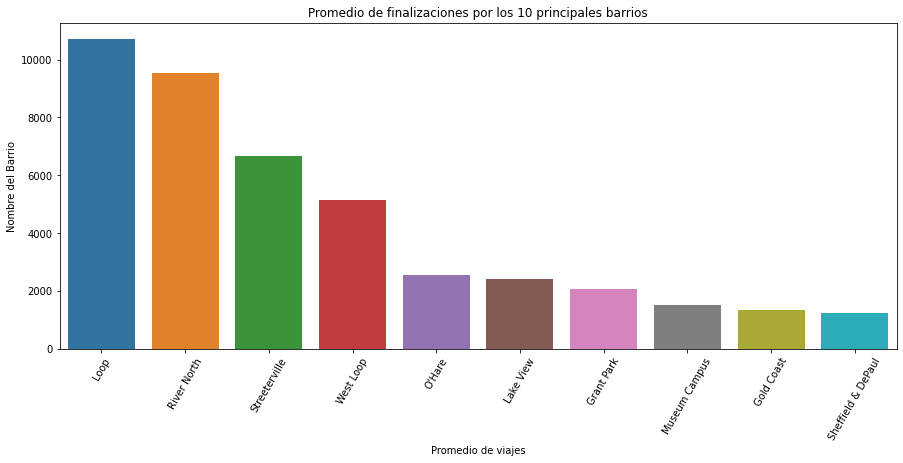

In [ ]:
# Se crea gráfico de barras para ver a detalle la diferencia entre los destinos

plt.figure(figsize=(15,6))
sns.barplot(x='dropoff_location_name', y='average_trips', data=top_location)
plt.title('Promedio de finalizaciones por los 10 principales barrios')
plt.xlabel('Promedio de viajes')
plt.ylabel('Nombre del Barrio')
plt.xticks(rotation=60)
plt.show()

Loop es el sector que cuenta con un promedio de más de 10000 viajes. Los detinos `Loop, River North, Streetville, West Loop` son los mas popluares, contando con más de 5000 paradas como destino final en la mayoría de los clientes. Esto seguramente se deba a la ubicación de los sitios turísticos en esta área, sectores financiero y de trabajo, lugares de recreación. 

# Número de viajes por compañía de taxis

In [ ]:
# Empresas de taxis y número de viajes

print(company_trips_info.describe())

       trips_amount
count     64.000000
mean    2145.484375
std     3812.310186
min        2.000000
25%       20.750000
50%      178.500000
75%     2106.500000
max    19558.000000


Como antes menciodando, solo el 25% de las empresas alcanza el promedio de la media de viajes. Por lo tanto, veamos de cerca cuales son esas empresas populares y veamos la distribución del rango de las qeu tienen mas viajes en comparación a las que tienen menos. 

In [ ]:
top_companies = company_trips_info.sort_values(by='trips_amount' , ascending = False).reset_index(drop=True)

display(top_companies.head(30))

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


Podemos ver que la diferencia de viajes entre cada compañía se vuelve mas homogenea a partir los 1000 viajes entre compañía y compañía. Por lo tanto filtraremos el estudio de información a contar de la compañías que tengan mas de 1000 viajes.

In [ ]:
# Se crea df filtrado con más de 1000 viajes

comp_1k = company_trips_info[company_trips_info['trips_amount'] > 1000]

display(comp_1k.head(3))

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367


 Veamos a escala la diferencia entre estas empresas creando un gráfico de barras con las compañías que tienen mas de 1000 viajes `comp_1k`

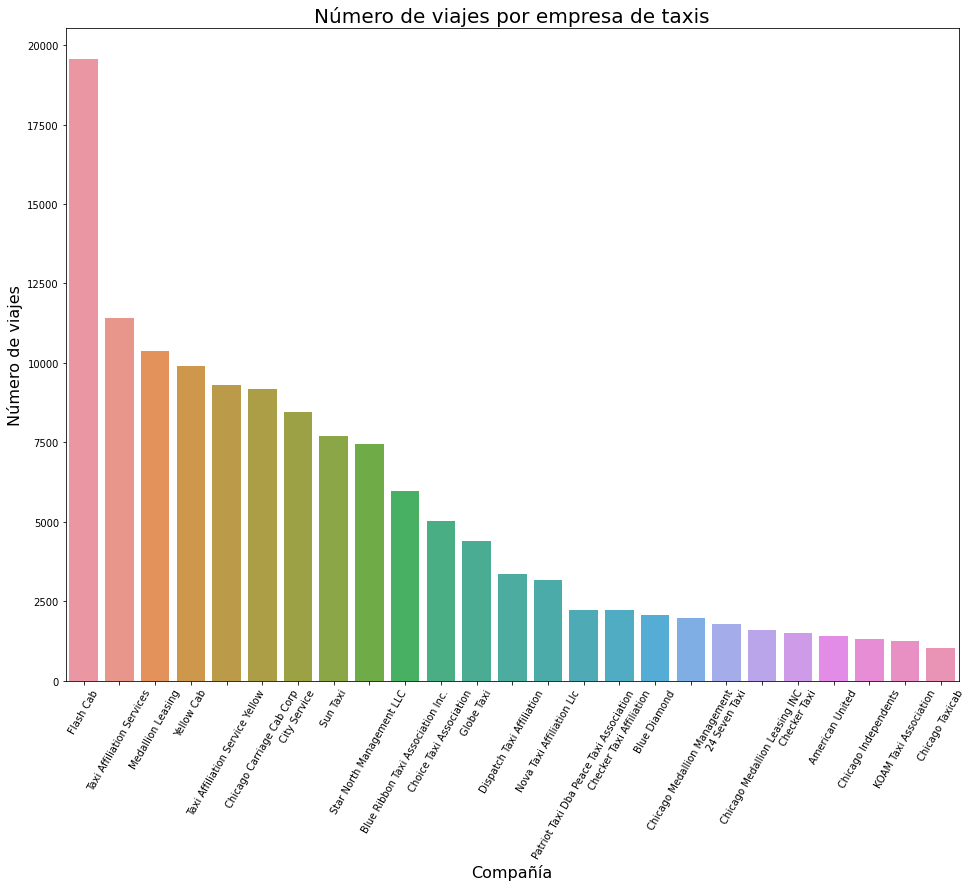

In [ ]:
plt.figure(figsize=(16, 12))
sns.barplot(x='company_name', y='trips_amount', data=comp_1k)
plt.title('Número de viajes por empresa de taxis', fontsize=20)
plt.xlabel('Compañía', fontsize=16)
plt.ylabel('Número de viajes', fontsize=16)
plt.xticks(rotation=60)  
plt.show()

De está compilación de viajes hecha entre el 15 y 16 de Noviembre, la compañia `Flash Cab` es por lejos las mas común y popular del mercado. En esta extracción obtuvo 19558 viajes. Se puede decir que es la mas popular para el uso cotidiano de la pobalción en Chicago, nisiquiera el segundo puesto (`Taxi Affiliation Services`) alcanza el 70% de lo viajes que representa `Flash Cab`.

Indiferentemente de ello, podemos notar un sub grupo de las empreasas mas populares, en el cuál podemos ver un rango desde ~7500 a ~11000 viajes. Se puede decir que `Flash Cab, Taxi Affliation Services, Medallion Leasing Yellow Cab, Taxi Afilliation Service Yellow, Chicago Carriage Cab Corp, City Service y Sun Taxi` son las empresas mas populares en la ciudad, y las demas su popularidad se puede basar más según el sector. 

# Prueba de Hipotesis

# Hipótesis: la duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos


Se ha sugerido que la duración promedio de los viajes del Loop al Aeropuerto Internacional O'Hare varía en los sábados lluviosos. Utilizando nuestro conjunto de datos weather_trips, que incluye la duración de los viajes y el estado del clima (Bueno o Malo) para los sábados de noviembre de 2017, investigaremos esta idea. Los datos están en el formato adecuado, con duplicados mantenidos ya que no tenemos la certeza de que sean errores y viajes de duración irregular eliminados.

Primero que todo, para poder evaluar nuestra hipotesis, separaremos los datos del df `weather_trips` según la columna `weather_conditions`. Recordemos que el clima fue categorizado por 2 opciones; 'good' , 'bad'. 

In [ ]:
# Se crean datasets separando los viajes según su condición climática 

bad_saturdays = weather_trips[(weather_trips['start_ts'].dt.dayofweek == 5) & (weather_trips['weather_conditions'] == 'Bad')]
good_saturdays = weather_trips[(weather_trips['start_ts'].dt.dayofweek == 5) & (weather_trips['weather_conditions'] == 'Good')]

Comprobemos la distribución de cada muestra:


  - `Distribución Similar`:  Realizaremos el test de Kolmogorov-Smirnov para comparar dos muestras con un nivel de significancia de 0.05. La hipótesis nula sugiere que las distribuciones son similares, mientras que la alternativa indica lo contrario. Si el valor p es mayor a 0.05, no podemos rechazar la hipótesis nula, lo que sugiere similitud en las distribuciones. Si es menor a 0.05, aceptaremos la hipótesis alternativa. Utilizaremos la función ks_2samp de scipy para este propósito.


 - `Distrubución Normal`: utilizaremos el test normalidad de Shapiro-Wilk con un nivel de significancia de 0.05, si el valor p es superior a 0.05 se acepta nuestra hipótesis nula y las muestras siguen una distribución normal, y si el valor p es inferior a 0.05, se rechaza la hipótesis nula y las muestras no presentan normalidad 
    

In [ ]:
#Distribución similar 

good = good_saturdays['duration_seconds']
bad =  bad_saturdays['duration_seconds']

alpha = 0.05


results = st.ks_2samp(good,bad)

print('pvalue:' , results.pvalue)

if results.pvalue < alpha: 
    print('Distribuciones diferentes')
else:
    print('Distribuciones similares')

pvalue: 1.827954589444427e-14
Distribuciones diferentes


In [ ]:
#Distribución Normales

good = good_saturdays['duration_seconds']
bad =  bad_saturdays['duration_seconds']

alpha = 0.05

results_good = shapiro(good)

print('pvalue good_saturdays:', results_good.pvalue)

if results_good.pvalue < alpha:
    print("Rechazamos la hipótesis nula: no hay normalidad")
else:
    print("No rechazamos la hipótesis nula: distribución normal")

    

print()
print()

results_bad = shapiro(bad)

print('pvalue bad_saturdays:' , results_bad.pvalue)

if results_bad.pvalue < alpha:
     print("Rechazamos la hipótesis nula: no hay normalidad")
else:
    print("No rechazamos la hipótesis nula: distribución normal")


pvalue good_saturdays: 8.819712425479925e-25
Rechazamos la hipótesis nula: no hay normalidad


pvalue bad_saturdays: 0.00037975297891534865
Rechazamos la hipótesis nula: no hay normalidad



Antes de iniciar nuestra prueba de hipótesis, necesitamos asegurarnos de que nuestras muestras, que no tienen distribuciones similares ni son normalmente distribuidas, tengan varianzas comparables. Para ello, emplearemos el test de Levene con un nivel de significancia de 0.05. Si el valor p es mayor que 0.05, indicará que las varianzas son similares entre las muestras. Por el contrario, si es menor, señalará diferencias en las varianzas. Utilizaremos el parámetro center=median en el test de Levene, ya que previamente determinamos que las muestras no siguen una distribución normal mediante el test de Shapiro.

In [ ]:
print('Varianza duración de viajes good_saturdays:', np.var(good_saturdays['duration_seconds']))
print('Varianza duración de viajes bad_saturdays:', np.var(bad_saturdays['duration_seconds']))

Varianza duración de viajes good_saturdays: 546281.00446281
Varianza duración de viajes bad_saturdays: 480136.0546963767


In [ ]:
# Prueba de igualdad en Varianzas

good = good_saturdays['duration_seconds']
bad = bad_saturdays['duration_seconds']
alpha = 0.05

results = levene(good, bad, center='median')

print('pvalue:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula: varianzas diferentes")
else:
    print("No rechazamos la hipótesis nula: varianzas iguales")

pvalue: 0.4248043185773904
No rechazamos la hipótesis nula: varianzas iguales


Ya que trabajaremos con muestras con distribuciones diferentes y sin normalidad, plantearemos nuestras hipótesis nula y alternativa.

`H0`: La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare es igual los sábados lluviosos como los sábados con buen clima.

`H1`: La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados con clima lluvioso o malo.

Ahora procederemos con nuestra prueba de hipótesis. Utilizaremos la prueba T-student para determinar si las medias aritméticas de nuestras dos muestras son iguales o no. Este test nos proporcionará un valor p, el cual compararemos con un nivel de significancia de 0.05 (alpha). Si el valor p es menor que alpha, rechazaremos la hipótesis nula en favor de la alternativa; de lo contrario, la aceptaremos.

Para realizar esta prueba, emplearemos la función st.ttest_ind de la librería scipy.stats. Esta función requiere como argumentos las dos muestras que estamos comparando: 'good' representará la duración de los viajes en sábados con buen clima, mientras que 'bad' será la duración de los viajes en sábados con clima lluvioso o malo. Estableceremos el argumento equal_var en True, ya que el test de Levene confirmó que las varianzas de las poblaciones son iguales. Finalmente, utilizaremos una estructura condicional if/else para determinar si rechazamos o aceptamos la H0 según el valor de alpha.

In [ ]:

# Realizar la prueba de hipótesis para la diferencia de medias

good = good_saturdays['duration_seconds']
bad = bad_saturdays['duration_seconds']

alpha = 0.05

t_stat, p_value = stats.ttest_ind(good, bad, equal_var=True)

# Imprimir los resultados

print("Resultados de la prueba de hipótesis:")
print("Estadístico t:", t_stat)

print('----------------------------------')


print("Valor p:", p_value)

print()

if p_value < alpha:
    print("Se rechaza la hipótesis nula. Hay suficiente evidencia para concluir que la duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia en los sábados lluviosos.")
else:
    print("No se rechaza la hipótesis nula. No hay suficiente evidencia para concluir que la duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia en los sábados lluviosos.")

Resultados de la prueba de hipótesis:
Estadístico t: -7.174910067937514
----------------------------------
Valor p: 1.3603319763146637e-12

Se rechaza la hipótesis nula. Hay suficiente evidencia para concluir que la duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia en los sábados lluviosos.


## Conclusiones

En el proceso de análisis de datos relacionados con los viajes en taxis en Chicago durante noviembre de 2017, se utilizaron tres conjuntos de datos obtenidos de bases de datos relacionales. Estos conjuntos de datos incluían información sobre el número de viajes por empresa de taxis, el promedio de viajes por barrio y las condiciones meteorológicas durante los viajes los días sábados entre el barrio Loop y el Aeropuerto O'Hare.

     - Procesamiento de datos:  
     
     En el primer conjunto de datos, que contenía el número de viajes por empresa de taxis, no se encontraron valores ausentes ni duplicados, y los tipos de datos fueron adecuados. En el segundo conjunto de datos, que mostraba el promedio de viajes por barrio, tampoco se encontraron valores ausentes ni duplicados, pero se redondearon los valores promedio y se convirtieron a tipo entero. En el tercer conjunto de datos, que incluía información sobre los viajes los días sábados entre el barrio Loop y el Aeropuerto O'Hare, no se registraron valores ausentes, pero se observaron duplicados que se atribuyeron a viajes realizados por taxis de diferentes compañías que comenzaron alrededor de la misma hora. Se mantuvieron estos duplicados, pero se eliminaron los viajes con una duración de cero segundos, que podrían ser viajes cancelados.
     
     - Análisis de datos:
     
     En cuanto al análisis exploratorio de datos, se encontró que la empresa de taxis Flash Cab registró el mayor número de viajes los días 15 y 16 de noviembre de 2017, seguida por Taxi Affiliation Services y Medallion Leasing. Esto sugiere que factores como la antigüedad en el mercado podrían influir en estos resultados, por otra parte se vio un sub-grupo que mantenía una medida notable de servicios, destacando la idea de que estas basan su popularidad según el sector. Además, se identificaron los diez barrios principales en términos de finalizaciones de viajes, lo que podría orientar las estrategias de marketing y distribución de unidades para una empresa como Zuber.
     
     - Prueba de Hipótesis:
     
     Finalmente, al probar la hipótesis sobre la duración de los viajes entre el barrio Loop y el Aeropuerto O'Hare en días con condiciones climáticas adversas, se encontró que la duración de los viajes aumentaba en estos días. Esto sugiere que el clima puede influir en la demanda de transporte en taxi, lo que tiene implicaciones para empresas como Zuber, que podrían beneficiarse de ofrecer viajes compartidos en días lluviosos para hacer frente al aumento del tráfico vehicular.